In [75]:
%load_ext autoreload
%autoreload 2

#import model
#import training
import loaders

import sys
from demoparser.demofile import DemoFile
import matplotlib.pyplot as plt
import time
import numpy as np

%load_ext tensorboard.notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import keras

Using TensorFlow backend.


Limited tf.compat.v2.summary API due to missing TensorBoard installation


In [3]:
g = loaders.Game(0)

Loading game 0
Round  0
Round  1
Round  2
Round  3
Round  4
Round  5
Round  6
Round  7
Round  8
Round  9
Round  10
Round  11
Round  12
Round  13
Round  14
Round  15
Round  16
Round  17
Round  18
Round  19
Round  20
Round  21
Round  22
Round  23
Round  24
Round  25
Finished loading game!


In [4]:
r = g.m_rounds[0]

#All player data for a round

l = max([len(p.states) for p in r.players])
print(l)

ls = [max([len(p.states) for p in rx.players]) for rx in g.m_rounds]
print(ls)

1392
[1392, 1742, 1840, 1853, 2007, 2060, 1173, 1614, 1329, 1920, 1838, 1488, 1695, 1446, 1812, 930, 1118, 1585, 1335, 1878, 2125, 980, 1979, 1139, 717, 1666]


In [62]:
import math

batch_size = 32
network_z, network_x, network_y = 10, 128, 128
blob_size = 2.5

def get_batches():
    for r in g.m_rounds:
        l = max([len(p.states) for p in r.players])
        print("Generating batches from round", r.m_rid, "length", l)

        for b_ix in range(l//batch_size):  # Ignore bits at end that don't make up a whole batch
            #print("Batch", b_ix)
            Y = np.zeros((batch_size, network_z, network_x, network_y))

            # Generate batch
            for f in range(batch_size):
                i = b_ix*batch_size + f  # index of frame in round

                # Draw blob for each player
                for p_ix, p in enumerate(r.players):
                    (pos, vis, dead) = p.states[i]
                    if not dead:
                        put_heatmap(Y[f, p_ix], pos)
            
            # Grab state data for each player
            states = []
            for p_ix, p in enumerate(r.players):
                states.append(p.states[b_ix*batch_size : (b_ix+1)*batch_size])

            # Reorder axis for input to network (ix,z,x,y) -> (ix,x,y,z)
            Y = np.moveaxis(Y, 1, -1)
            yield Y, states

btchs = get_batches()
#next(btchs)

Generating batches from round 0 length 1392
(32, 10, 128, 128)
(128, 128)


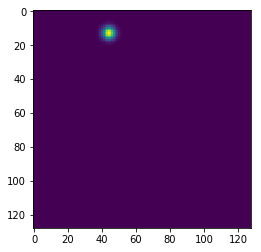

In [30]:
Y,_ = next(btchs)
print(Y.shape)
a = Y[0,0]
print(a.shape)
plt.imshow(Y[30,9])

Generating batches from round 0 length 1392
Generating batches from round 1 length 1742
Generating batches from round 2 length 1840
Generating batches from round 3 length 1853
Generating batches from round 4 length 2007
Generating batches from round 5 length 2060
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
Generating batches from round 8 length 1329
Generating batches from round 9 length 1920
Generating batches from round 10 length 1838
Generating batches from round 11 length 1488
Generating batches from round 12 length 1695
Generating batches from round 13 length 1446
Generating batches from round 14 length 1812
Generating batches from round 15 length 930
Generating batches from round 16 length 1118
Generating batches from round 17 length 1585
Generating batches from round 18 length 1335
Generating batches from round 19 length 1878
Generating batches from round 20 length 2125
Generating batches from round 21 length 980
Generating batches fro

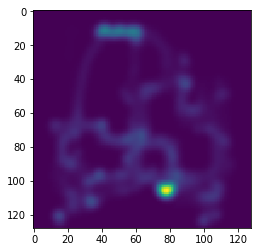

In [21]:
# Lil experiment, Sum all positions

yave = np.zeros((128,128))

for Y,_ in btchs:
    yave += np.sum(Y, axis=(0,1)) / (batch_size * network_z)
    
plt.imshow(yave)

In [7]:

# Get a batch of frames.
# This only gives the network target output, we have to generate it's input ourselves.
def get_next_batch():
    Y = np.empty((batch_size, network_z, network_x, network_y))

    # Only bother with full batches
    if current_frame + batch_size > len(something):
        return None

    for i in range(batch_size):
        Y[i,:] = get_frame(current_frame)
        current_frame += 1
    return Y

# Generate frame i
def get_frame(i):
    f = np.zeros((network_z, network_x, network_y))

    for p_ix in range(network_z):
        if is_alive(p_ix, i):
            put_heatmap(f[p_ix], x, y)

    return np.empty()

# Put a blob in the required place of a 2d matrix
# Can do this way faster, but it's fine for now..
def put_heatmap(heatmap, center):
    center_x, center_y = center
    
    # Rescale ..
    x1, x2, y1, y2 = (-2600., 2100., -1200., 3200.)

    center_x = (center_x - x1) / (x2 - x1) * network_x
    center_y = (center_y - y1) / (y2 - y1) * network_y
    
    height, width = heatmap.shape

    th = 4.6052
    
    delta = math.sqrt(th * 2)

    # Vectorize
    sigma = blob_size
    x0 = int(max(0, center_x - delta * sigma))
    y0 = int(max(0, center_y - delta * sigma))

    x1 = int(min(width - 1, center_x + delta * sigma))
    y1 = int(min(height - 1, center_y + delta * sigma))

    exp_factor = 1 / 2.0 / sigma / sigma
    arr_heatmap = heatmap[y0:y1 + 1, x0:x1 + 1] # Not nessasary unless we have > 1 blob per input
    y_vec = (np.arange(y0, y1 + 1) - center_y) ** 2  # y1 included
    x_vec = (np.arange(x0, x1 + 1) - center_x) ** 2
    xv, yv = np.meshgrid(x_vec, y_vec)
    arr_sum = exp_factor * (xv + yv)
    arr_exp = np.exp(-arr_sum)
    arr_exp[arr_sum > th] = 0
    
    heatmap[y0:y1 + 1, x0:x1 + 1] = np.maximum(arr_heatmap, arr_exp)


In [71]:
# Do teh learning!

from model import unet
model = unet(pretrained_weights="csgo_zero.h5", input_size=(128,128,10))

/csgo/CSGO_Map_Model/model.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [36]:
#print(Y.shape)
#Y = next(batch)

X = np.moveaxis(Y, 1, -1)
print(X.shape)

Yp = model.predict(X)
print(Yp.shape)
#model.train_on_batch(Y,Y)

(32, 128, 128, 10)
(32, 128, 128, 10)


In [ ]:
num_epochs = 100
debug = False

def train_network():
    step = 0
    for e in range(num_epochs):
        
        btchs = get_batches()
        # Just dump first batch pretty much

        Y0, _ = next(btchs)

        # Initial state is just the very first frame of the game,
        # which is known to both sides anyway(!)
        # After the first loop, it'll be a prediction of the first frame in the batch.
        c_frame = Y0[-1]

        # Frame index for input vs output.
        # k(ix) = global knowledge from frame ix

        # input (X)       | output (Y)
        # ----------------------------
        # 0               | 1
        # pred(0) + k(1)  | 2
        # pred(x1) + k(2) | 3
        # pred(x2) + k(3) | 4

        #while True:
        for Y, states in btchs:
            # Each loop here creates a new training batch and updates the network based on it.

            # Make batch input
            X = np.empty((batch_size, network_x, network_y, network_z))

            for f_ix in range(batch_size):
                # Add current frame to batch (copying)
                # This way, X always lags behind Y by one frame.
                X[f_ix,:] = c_frame

                # Predict next frame (f_ix) based on current one (expanding and reducing dimensions cause stuff)
                c_frame = model.predict(np.expand_dims(c_frame, axis=0))[0]

                # Update with any knowledge we have. (i.e. player visible or dead)
                #ix = starting_frame + f_ix  # current frame index

                for p_id in range(network_z):
                    _, is_spotted, is_dead = states[p_id][f_ix]
                    if p_id < 5 or is_spotted or is_dead:
                        # If player is dead or visible, we now know what it's doing...
                        # update it's layer to the ground truth. (of what will be effectively the previous frame)
                        c_frame[:,:,p_id] = Y[f_ix,:,:,p_id]

            # Train model!!! on our newly created X and Y batches (:D)
            loss = model.train_on_batch(X, Y)
            
            
            if step % 100 == 0:
                print(loss)
            step += 1
          

    #model.save('csgo_{}.h5'.format(e))  # creates a HDF5 file 'my_model.h5'
    if e % 3 == 0:
        model.save('csgo_zero.h5')

train_network()

Generating batches from round 0 length 1392
[0.55354244, 0.988971]
Generating batches from round 1 length 1742
Generating batches from round 2 length 1840
[0.54946613, 0.9889221]
Generating batches from round 3 length 1853
[0.5453423, 0.9900656]
Generating batches from round 4 length 2007
Generating batches from round 5 length 2060
[0.5413934, 0.9891633]
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
[0.5372437, 0.99114364]
Generating batches from round 8 length 1329
Generating batches from round 9 length 1920
[0.53327256, 0.99119437]
Generating batches from round 10 length 1838
Generating batches from round 11 length 1488
[0.5293304, 0.9911646]
Generating batches from round 12 length 1695
Generating batches from round 13 length 1446
[0.5254991, 0.990139]
Generating batches from round 14 length 1812
Generating batches from round 15 length 930
[0.5214109, 0.99261767]
Generating batches from round 16 length 1118
Generating batches from round 17 le

[0.32269382, 0.9889435]
Generating batches from round 17 length 1585
Generating batches from round 18 length 1335
[0.31876916, 0.9955857]
Generating batches from round 19 length 1878
Generating batches from round 20 length 2125
[0.31766048, 0.9889593]
Generating batches from round 21 length 980
Generating batches from round 22 length 1979
[0.31445688, 0.99227756]
Generating batches from round 23 length 1139
Generating batches from round 24 length 717
Generating batches from round 25 length 1666
[0.31269845, 0.9889388]
Generating batches from round 0 length 1392
Generating batches from round 1 length 1742
[0.3100044, 0.99004805]
Generating batches from round 2 length 1840
Generating batches from round 3 length 1853
[0.30781093, 0.9889664]
Generating batches from round 4 length 2007
[0.30416048, 0.99448586]
Generating batches from round 5 length 2060
Generating batches from round 6 length 1173
[0.30174676, 0.9944769]
Generating batches from round 7 length 1614
Generating batches from rou

Generating batches from round 7 length 1614
[0.18217444, 0.9900815]
Generating batches from round 8 length 1329
Generating batches from round 9 length 1920
[0.18108006, 0.9889914]
Generating batches from round 10 length 1838
Generating batches from round 11 length 1488
[0.17961228, 0.98896486]
Generating batches from round 12 length 1695
Generating batches from round 13 length 1446
[0.17815658, 0.98896486]
Generating batches from round 14 length 1812
Generating batches from round 15 length 930
[0.17671175, 0.988971]
Generating batches from round 16 length 1118
Generating batches from round 17 length 1585
[0.17249289, 0.9967066]
Generating batches from round 18 length 1335
Generating batches from round 19 length 1878
[0.17145479, 0.9955805]
Generating batches from round 20 length 2125
Generating batches from round 21 length 980
[0.17002961, 0.9955988]
Generating batches from round 22 length 1979
Generating batches from round 23 length 1139
Generating batches from round 24 length 717
[0.

[0.102859244, 0.99004483]
Generating batches from round 23 length 1139
Generating batches from round 24 length 717
Generating batches from round 25 length 1666
[0.102570355, 0.9889588]
Generating batches from round 0 length 1392
Generating batches from round 1 length 1742
[0.10175214, 0.988971]
Generating batches from round 2 length 1840
[0.099815056, 0.9913954]
Generating batches from round 3 length 1853
Generating batches from round 4 length 2007
[0.09904057, 0.9911734]
Generating batches from round 5 length 2060
Generating batches from round 6 length 1173
[0.099336945, 0.98896337]
Generating batches from round 7 length 1614
Generating batches from round 8 length 1329
[0.09522787, 0.9956106]
Generating batches from round 9 length 1920
Generating batches from round 10 length 1838
[0.09706348, 0.99034643]
Generating batches from round 11 length 1488
Generating batches from round 12 length 1695
[0.09697608, 0.98897505]
Generating batches from round 13 length 1446
Generating batches from

[0.0580868, 0.9911804]
Generating batches from round 13 length 1446
Generating batches from round 14 length 1812
[0.0552751, 0.9949312]
Generating batches from round 15 length 930
Generating batches from round 16 length 1118
Generating batches from round 17 length 1585
[0.056504272, 0.99226934]
Generating batches from round 18 length 1335
Generating batches from round 19 length 1878
[0.055996597, 0.9923916]
Generating batches from round 20 length 2125
Generating batches from round 21 length 980
[0.057729147, 0.98896456]
Generating batches from round 22 length 1979
Generating batches from round 23 length 1139
[0.05730349, 0.98896694]
Generating batches from round 24 length 717
Generating batches from round 25 length 1666
Generating batches from round 0 length 1392
[0.056884155, 0.9889597]
Generating batches from round 1 length 1742
Generating batches from round 2 length 1840
[0.056468207, 0.98895496]
Generating batches from round 3 length 1853
Generating batches from round 4 length 2007

Generating batches from round 2 length 1840
[0.035423234, 0.9905913]
Generating batches from round 3 length 1853
Generating batches from round 4 length 2007
[0.035590615, 0.99006104]
Generating batches from round 5 length 2060
[0.031972118, 0.99448335]
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
Generating batches from round 8 length 1329
[0.035984486, 0.9889521]
Generating batches from round 9 length 1920
Generating batches from round 10 length 1838
[0.03576043, 0.9889635]
Generating batches from round 11 length 1488
Generating batches from round 12 length 1695
[0.035538975, 0.9889771]
Generating batches from round 13 length 1446
Generating batches from round 14 length 1812
[0.03532224, 0.9889573]
Generating batches from round 15 length 930
Generating batches from round 16 length 1118
[0.033470877, 0.9910767]
Generating batches from round 17 length 1585
Generating batches from round 18 length 1335
Generating batches from round 19 length 1878

Generating batches from round 17 length 1585
[0.025074365, 0.9889483]
Generating batches from round 18 length 1335
Generating batches from round 19 length 1878
[0.023840955, 0.9901974]
Generating batches from round 20 length 2125
[0.0158772, 0.9988953]
Generating batches from round 21 length 980
Generating batches from round 22 length 1979
Generating batches from round 23 length 1139
[0.02473518, 0.9889588]
Generating batches from round 24 length 717
Generating batches from round 25 length 1666
[0.021491677, 0.9925715]
Generating batches from round 0 length 1392
Generating batches from round 1 length 1742
Generating batches from round 2 length 1840
[0.024523837, 0.9889221]
Generating batches from round 3 length 1853
[0.02435408, 0.9891846]
Generating batches from round 4 length 2007
Generating batches from round 5 length 2060
[0.024312401, 0.98896277]
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
[0.02218935, 0.99116004]
Generating batches from

[0.015015947, 0.99337125]
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
[0.014954239, 0.9934056]
Generating batches from round 8 length 1329
Generating batches from round 9 length 1920
[0.012609977, 0.9955792]
Generating batches from round 10 length 1838
Generating batches from round 11 length 1488
[0.013692946, 0.9944592]
Generating batches from round 12 length 1695
Generating batches from round 13 length 1446
[0.012307955, 0.9957479]
Generating batches from round 14 length 1812
Generating batches from round 15 length 930
Generating batches from round 16 length 1118
[0.019325841, 0.9889624]
Generating batches from round 17 length 1585
Generating batches from round 18 length 1335
[0.012366993, 0.99557745]
Generating batches from round 19 length 1878
Generating batches from round 20 length 2125
[0.019211393, 0.9890766]
Generating batches from round 21 length 980
Generating batches from round 22 length 1979
[0.016871214, 0.991173]
Generating batc

[0.010914579, 0.99448323]
Generating batches from round 21 length 980
Generating batches from round 22 length 1979
[0.0108836405, 0.9944575]
Generating batches from round 23 length 1139
Generating batches from round 24 length 717
Generating batches from round 25 length 1666
[0.015999876, 0.99006444]
Generating batches from round 0 length 1392
Generating batches from round 1 length 1742
[0.015981562, 0.9900744]
Generating batches from round 2 length 1840
Generating batches from round 3 length 1853
[0.017171085, 0.9891999]
Generating batches from round 4 length 2007
Generating batches from round 5 length 2060
[0.017239561, 0.9889653]
Generating batches from round 6 length 1173
Generating batches from round 7 length 1614
[0.017223898, 0.9889637]
Generating batches from round 8 length 1329


In [77]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 5863), started 0:01:20 ago. (Use '!kill 5863' to kill it.)